In [42]:
from functions.FullBending import FullBending
import pandas as pd

In [43]:
# E [GPa]
# nucleo	4.22
# X	26.95
# SX	13.57
# Y	97.86
# SY	4.22

df_layers = pd.DataFrame({ 'E': [0.800000,
                                 5.198613, 
                                 2.814443, 
                                 21.284290, 
                                 5.775806]}, index=['nucleo', 'X', 'SX', 'Y', 'SY'])

In [44]:
df_layers

,E
nucleo,0.800000
X,5.198613
SX,2.814443
Y,21.284290
SY,5.775806


In [45]:
from validation.BendingExperimental import BendingExperimental

r = BendingExperimental()

df_stats = r["df_stats"]

layers = df_stats["layers"]
layers[0] = ["Y","Y"]
df_stats["layers"] = layers

C:\Users\djoroya\AppData\Local\Temp\ipykernel_9564\3445370218.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layers[0] = ["Y","Y"]
C:\Users\djoroya\AppData\Local\Temp\ipykernel_9564\3445370218.py:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  layers[0] = ["Y","Y"]


In [46]:
df_stats

Eb [GPa]              t [mm]               b [mm]            \
           mean       std      mean       std       mean       std   
Name                                                                 
TFP1  13.201050  0.630858  5.266667  0.057735  25.600000  0.100000   
TFP2   9.869501  0.780113  4.700000  0.000000  25.566667  0.057735   
TFP3   9.222003  0.495965  4.833333  0.057735  25.400000  0.173205   
TFP4  10.181815  0.770635  4.700000  0.000000  25.666667  0.152753   
TFP5   6.143105  0.161637  5.700000  0.000000  25.166667  0.152753   
TFP6   7.798060  0.334186  5.600000  0.000000  25.033333  0.635085   

        Sb [MPa]                  layers v [X,SX,Y,SY] ni  
            mean        std                                
Name                                                       
TFP1  134.996667  18.942693       [Y, Y]  [0, 0, 1, 0]  1  
TFP2  117.430000  15.759607       [Y, X]  [1, 0, 1, 0]  2  
TFP3  128.053333   5.337905      [Y, SX]  [0, 1, 1, 0]  2  
TFP4  141.703333   7.525386      [Y, SY]  [0, 0, 1, 1]  2  
TFP5  107.433333   3.902939  [Y, SX, SY]  [0, 1, 1, 1]  3  
TFP6  114.306667  11.800790   [Y, X, SY]  [1, 0, 1, 1]  3

In [47]:

import os 
from copy import deepcopy
join = os.path.join

E_pred = []

if not os.path.exists("output"):
    os.mkdir("output")

params = {
            "geo" : {
                        "t_n" : 3.073400,
                        "t_l" : 0.427120,
                        "Lx"  : 30,
                        "meshsizefactor" : 1.1
                    },
            "sim" : {
                        "disp" : 5.0,
                        "opt": {
                                "OMP_NUM_THREADS":4,
                                "mpi_np":4,
                                "mpi":True
                                },
                    },
        }


all_params = []

id_design = 0
E_n =   df_layers.loc["nucleo"].values[-1]*1e3

lyrs = df_stats["layers"].iloc[id_design]

print("\n\nLayers: ", lyrs, "\n\n")
E_l = df_layers.loc[lyrs]["E"].values*1e3 # MPa
name_mat = df_stats["layers"].iloc[id_design]
name = df_stats.index[id_design]
B    = df_stats["b [mm]"]["mean"].iloc[id_design]

params_loop = deepcopy(params)

B = 25
params_loop["geo"]["Ly"] = B
params_loop["sim"]["E_n"] = E_n
params_loop["sim"]["E_l"] = E_l
params_loop["sim"]["name_mat"] = name_mat
params_loop["output_folder"] = join("output_YY")

print(params)
inp_f = FullBending(params_loop)
Eflex_FEM = params_loop["Eflex"]




Layers:  ['Y', 'Y'] 


{'geo': {'t_n': 3.0734, 't_l': 0.42712, 'Lx': 30, 'meshsizefactor': 1.1}, 'sim': {'disp': 5.0, 'opt': {'OMP_NUM_THREADS': 4, 'mpi_np': 4, 'mpi': True}}}
Running Calculix at:  output_YY\sim
Output file:  c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts\T02_Modelo_MultiCapa\T01_NumericalBasic\output_YY\sim\out.txt
Command:
 C:\Program Files\Microsoft MPI\Bin\mpiexec -n 4 c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\.conda\Lib\site-packages\djccx\bin\ccx_dynamic.exe main
Error reading cvf file

pid:  6952 

Calculix finished



In [48]:
def E_flex_inercia(E_n,E_l,t_n,t_l,B):

    ni = 2
    t_t = t_n + 2*t_l*ni
    # print(t_t)


    I_tot = (1/12)*B*t_t**3

    yG1 = t_n*0.5 + t_l*0.5
    I_l1   = (1/12)*B*t_l**3 + B*t_l*yG1**2

    yG2 = yG1 + t_l
    I_l2   = (1/12)*B*t_l**3 + B*t_l*yG2**2

    I_n   = (1/12)*B*t_n**3 


    Eflex = (E_n*I_n + 2*E_l*I_l1 + 2*E_l*I_l2)/(I_tot)

    return Eflex*1e-3 # GPa

In [49]:
t_n = params_loop["geo"]["t_n"]
t_l = params_loop["geo"]["t_l"]

In [50]:
print("E_n", E_n)
print("E_l", E_l[0])
print("tn",t_n)
print("tl",t_l)
print("B",B)

E_n 800.0
E_l 21284.289999999997
tn 3.0734
tl 0.42712
B 25


In [51]:
Eflex_pred_inercia = E_flex_inercia(E_n,E_l[0],t_n,t_l,B)

In [52]:
def E_tracion_an(E_n,E_l,t_n,t_l):

    t_t = t_n + 2*2*t_l

    Etrac = (E_n*t_n + 2*2*E_l*t_l)/(t_t)

    return Etrac*1e-3 # GPa

In [53]:
from AnalyticalLayers.models import E_flexion  as E_flexion_fcn

In [54]:
t_n = params_loop["geo"]["t_n"]
t_l = params_loop["geo"]["t_l"]

Eflex_pred = E_flex_inercia(E_n,
                          E_l[0],
                          t_n,
                          t_l,B)

Eflex_pred_fcn = E_flexion_fcn(E_n,
                           [0,0,E_l[0],0],
                           t_n,
                           t_l,layers=lyrs)
Eflex_pred_fcn = Eflex_pred_fcn*1e-3

In [55]:
Eflex_pred - params_loop["Eflex"]

print("Analitico: ", Eflex_pred)
print("Simulado: ", Eflex_FEM)
print("Analitico fcn: ", Eflex_pred_fcn)    


Analitico:  15.845752140285695
Simulado:  12.117674481051068
Analitico fcn:  15.845752140285695


In [56]:
print("Error (%) : ", abs(Eflex_pred - Eflex_FEM)/Eflex_FEM*100)

Error (%) :  30.765619798290366


In [57]:
x0 = 0
y0 = B/2
eps = 0.1
ifrd = inp_f.frd
ifrd = ifrd.copy()

ifrd = ifrd[ (ifrd["x"] > x0 - eps) & (ifrd["x"] < x0 + eps) ]
ifrd = ifrd[ (ifrd["y"] > y0 - eps) & (ifrd["y"] < y0 + eps) ]
ifrd

,x,y,z,D1,D2,D3,SXX,SYY,SZZ,SXY,...,EYZ,EZX,F1,F2,F3,STR(%),S_von_mises,P1,P2,P3
nid,,,,,,,,,,,,,,,,,,,,,
111,0.000000,12.500000,-1.536700,0.000000,0.023467,-4.91704,141.3910,-8.61498,-6.86249,-0.002040,...,1.779010e-05,-9.636740e-07,-2.326100e+00,2.267570e-13,-1.297200e-12,4.86052,149.137462,141.391000,-6.862266,-8.615204
207,0.000000,12.500000,-1.963820,0.000000,0.023484,-4.91440,528.9110,57.33400,-2.44638,-0.001367,...,2.342480e-06,3.602360e-07,-8.159410e+00,1.378980e-12,-1.904670e-12,3.51007,504.132540,528.911000,57.334025,-2.446405
303,0.000000,12.500000,1.536700,0.000000,0.023574,-4.99454,72.5983,57.25950,-44.18540,0.184117,...,9.512970e-05,-7.665830e-05,-5.518720e-01,4.185850e-14,-2.976580e-13,16.41270,109.926209,72.604146,57.257311,-44.189057
399,0.000000,12.500000,1.963820,0.000000,0.023464,-4.99541,-473.4640,-84.87070,-167.99000,-0.319361,...,2.415670e-04,5.626860e-04,7.506420e+00,6.855190e-13,-3.057000e-12,11.45370,354.846188,-84.682894,-167.899728,-473.742078
438,0.000000,12.500000,-2.390940,0.000000,0.023501,-4.90986,786.0110,129.35200,0.03215,-0.001782,...,1.819860e-07,-1.226120e-06,-5.987510e+00,-5.290350e-13,-1.058760e-13,2.37338,729.961445,786.011001,129.352000,0.032149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9755,0.095358,12.513412,1.442160,0.000534,0.023629,-4.98994,-12.4375,-13.12690,-42.48900,0.007961,...,1.860730e-04,3.897530e-03,1.680980e-13,-1.009790e-13,4.363180e-14,13.07990,30.002468,-12.246948,-13.126792,-42.679660
9756,0.095358,12.405910,1.455194,0.000544,0.023174,-4.99058,-12.4685,-13.12070,-42.73010,0.009340,...,2.664230e-04,3.899860e-03,1.057780e-13,-1.980460e-13,-3.095860e-13,13.60170,30.229337,-12.278771,-13.120397,-42.920132
9808,0.095358,12.515731,1.645648,-0.000169,0.023616,-4.99464,-45.7621,65.96720,-62.44840,0.319009,...,2.043920e-05,7.406160e-04,-1.242510e-12,2.131630e-12,9.693150e-12,23.72620,122.751636,65.969184,-39.388268,-68.824215


In [58]:
#sort by z
ifrd = ifrd.sort_values("z")

In [59]:
from matplotlib import pyplot as plt

(-200.0, 850.0)

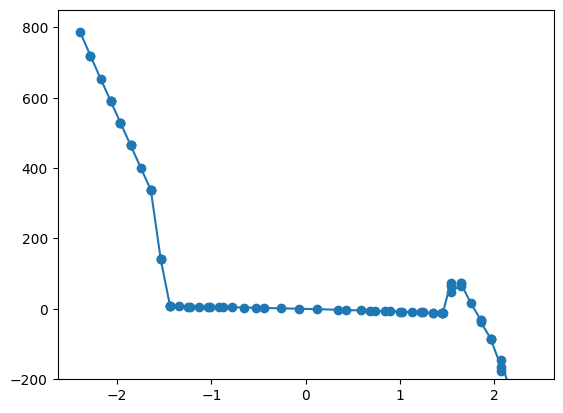

In [60]:
# plot 
plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
plt.ylim([-200,850])

In [61]:
ifrd["P1"].values[0]

np.float64(786.0110005175686)

In [62]:
E_eff = E_tracion_an(E_n,E_l[0],t_n,t_l)

In [63]:
E_eff

np.float64(8.118669598400627)

In [64]:
ifrd["x"]

nid
438      0.000000
3845     0.000000
3846     0.000000
3777     0.000000
3814     0.000000
           ...   
10763    0.095358
5580     0.000000
5648     0.000000
5649     0.000000
557      0.000000
Name: x, Length: 76, dtype: float64

In [65]:
ifrd = inp_f.frd
ifrd = ifrd.copy()
# sort 
ifrd = ifrd.sort_values("z")
P = -ifrd["F3"][ifrd["x"] < ifrd["x"].mean()].values
# P = ifrd["F3"].values
P = 2*P.sum()


L = 2*params["geo"]["Lx"]
tl = params["geo"]["t_l"]
tn = params["geo"]["t_n"]
D = 2*tl + tn

In [66]:
B

25

In [67]:
D

3.92764

In [68]:
P

np.float64(3067.1255600573763)

In [69]:
sigma_max = (3/2)*P*L/(B*D**2)
sigma_max

np.float64(715.7654107013882)

In [70]:
# plot 

ifrd = ifrd[ (ifrd["x"] > x0 - eps) & (ifrd["x"] < x0 + eps) ]
ifrd = ifrd[ (ifrd["y"] > y0 - eps) & (ifrd["y"] < y0 + eps) ]


In [71]:
E_l

array([21284.29, 21284.29])

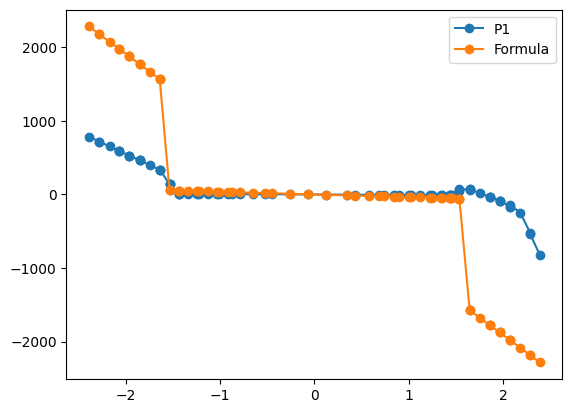

In [72]:

plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
z = ifrd["z"]
zmax = D/2
sigma_i_an = -sigma_max*(E_l[0]/E_eff*(z/zmax) )*(z<-t_n/2) + \
             -sigma_max*(E_n/E_eff   *(z/zmax) )*(z>=-t_n/2)*(z<=t_n/2) + \
             -sigma_max*(E_l[0]/E_eff*(z/zmax) )*(z>t_n/2)

plt.plot(z, sigma_i_an*1e-3, label="Formula",marker="o")
#plt.ylim([-200,850])
plt.legend()

(-100.0, 100.0)

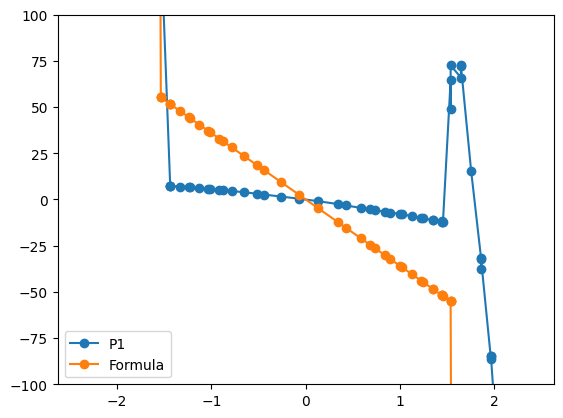

In [73]:
sigma_i_an
plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
z = ifrd["z"]
zmax = D/2
sigma_i_an = -sigma_max*(E_l[0]/E_eff*(z/zmax) )*(z<-t_n/2) + \
             -sigma_max*(E_n/E_eff   *(z/zmax) )*(z>=-t_n/2)*(z<=t_n/2) + \
             -sigma_max*(E_l[0]/E_eff*(z/zmax) )*(z>t_n/2)

plt.plot(z, sigma_i_an*1e-3, label="Formula",marker="o")
#plt.ylim([-200,850])
plt.legend()
plt.ylim([-100,100])

In [74]:
Eflex_pred

np.float64(15.845752140285695)

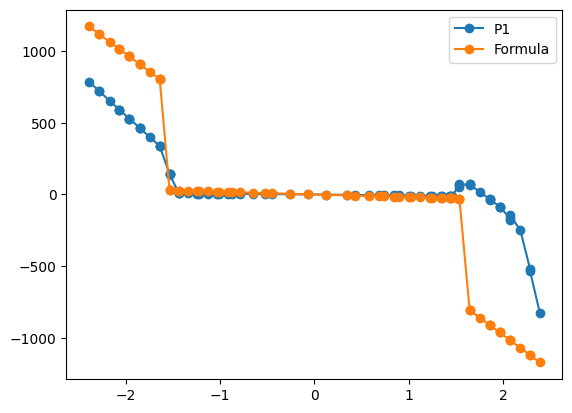

In [75]:

plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
z = ifrd["z"]
zmax = D/2
sigma_i_an = -sigma_max*((E_l[0]/Eflex_pred)*(z/zmax) )*(z<-t_n/2) + \
             -sigma_max*((E_n   /Eflex_pred)*(z/zmax) )*(z>=-t_n/2)*(z<=t_n/2) + \
             -sigma_max*((E_l[0]/Eflex_pred)*(z/zmax) )*(z>t_n/2)

plt.plot(z, sigma_i_an*1e-3, label="Formula",marker="o")
#plt.ylim([-200,850])
plt.legend()

(-100.0, 100.0)

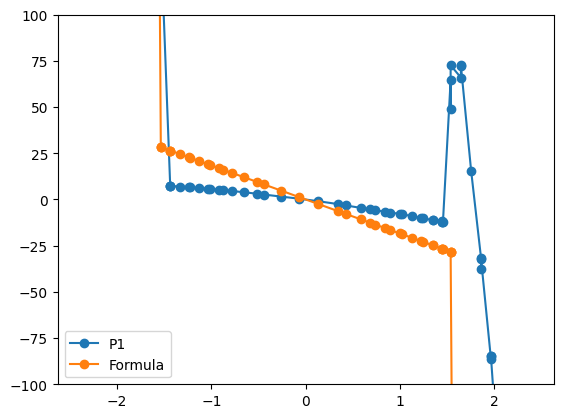

In [76]:

plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
z = ifrd["z"]
zmax = D/2
sigma_i_an = -sigma_max*((E_l[0]/Eflex_pred)*(z/zmax) )*(z<-t_n/2) + \
             -sigma_max*((E_n   /Eflex_pred)*(z/zmax) )*(z>=-t_n/2)*(z<=t_n/2) + \
             -sigma_max*((E_l[0]/Eflex_pred)*(z/zmax) )*(z>t_n/2)

plt.plot(z, sigma_i_an*1e-3, label="Formula",marker="o")
#plt.ylim([-200,850])
plt.legend()
plt.ylim([-100,100])

In [77]:
D

3.92764

In [78]:
U = params["sim"]["disp"]
E_flexion_formula = P*L**3/(4*U*B*D**3)*1e-3

In [79]:
E_flexion_formula

np.float64(21.868564655662585)

In [80]:
Eflex_pred

np.float64(15.845752140285695)

In [81]:
E_eff

np.float64(8.118669598400627)

In [82]:
E_flexion_formula/(1-0.3**2)

np.float64(24.031389731497345)